In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from konlpy.tag import Hannanum
from konlpy.tag import Komoran
from hanspell import spell_checker
import re
from konlpy.tag import Okt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Kkma
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
#from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from soynlp.normalizer import *
from soynlp.utils import DoublespaceLineCorpus
from soynlp.noun import LRNounExtractor_v2

In [2]:
df = pd.read_csv('./result/2021-04-16_구글 마켓컬리.csv')

In [3]:
df = df[['date', 'comment', 'ratings']]

In [4]:
df = df.dropna(axis = 0, how = 'any')
df = df.reset_index()
del df['index']

In [5]:
from soyspacing.countbase import CountSpace
def 띄어쓰기(text):
    verbose=False
    mc = 10  # min_count
    ft = 0.3 # force_abs_threshold
    nt =-0.3 # nonspace_threshold
    st = 0.3 # space_threshold


    sent_corrected, tags = model.correct(
    doc=text,
    verbose=verbose,
    force_abs_threshold=ft,
    nonspace_threshold=nt,
    space_threshold=st,
    min_count=mc)
    sent_corrected, tags = model.correct(text)
    result = sent_corrected
    return result
corpus_fname = './result/134963_norm.txt'
model = CountSpace()
model.train(corpus_fname)    

df['comment'] = df['comment'].apply(lambda x: 띄어쓰기(x))
df.head()
    
    

all tags length = 694236 --> 57795, (num_doc = 15602)

,date,comment,ratings
0,2021-04-16,너무편리해요,5
1,2021-04-16,깔끔한 앱,5
2,2021-04-16,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 5000원만 딱3000원 더 골르면 더...,1
3,2021-04-16,빠른배송감사합니다,5
4,2021-04-16,물품다양 고퀄리티 원료굿 배송굿 서비스굿,5


In [6]:
#맞춤법 검사기
for i in tqdm(range(len(df))): 
    try: 
        result = spell_checker.check(df['comment'][i])
        a= result[1]
        df['comment'][i] = a
    except: 
        pass



D:\programfiles\anaconda3\envs\pythonopencv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
def text_cleaning(text):
    result = only_hangle(text)
    result = repeat_normalize(result, num_repeats=2) #반복적인 단어 응축(2번 이상인것들)
    result = emoticon_normalize(result,num_repeats=2) #반복적인 자음,모음 응축(2번 이상인것들)
    return result
df['ko_text'] = df['comment'].apply(lambda x: text_cleaning(x))
df.head()

,date,comment,ratings,ko_text
0,2021-04-16,너무편리해요,5,너무편리해요
1,2021-04-16,깔끔한 앱,5,깔끔한 앱
2,2021-04-16,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 5000원만 딱3000원 더 골르면 더...,1,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 원만 딱 원 더 골르면 더있음 쿠폰쓸수...
3,2021-04-16,빠른배송감사합니다,5,빠른배송감사합니다
4,2021-04-16,물품다양 고퀄리티 원료굿 배송굿 서비스굿,5,물품다양 고퀄리티 원료굿 배송굿 서비스굿


In [8]:
from soynlp.word import WordExtractor
from soynlp.utils import DoublespaceLineCorpus
from soynlp.tokenizer import LTokenizer
word_extractor = WordExtractor(min_frequency=100,
   min_cohesion_forward=0.05,
   min_right_branching_entropy=0.0
)
word_extractor.train(df['ko_text'].values)
words = word_extractor.extract()
words

cohesion_score = {word:score.cohesion_forward for word, score in words.items()}
tokenizer = LTokenizer(scores=cohesion_score)


training was done. used memory 0.743 Gb
all cohesion probabilities was computed. # words = 190
all branching entropies was computed # words = 8459
all accessor variety was computed # words = 8459


In [9]:
df['nouns'] = df['ko_text'].apply(lambda x: tokenizer.tokenize(x, remove_r=True)) # L과 R 분리하여 R은 삭제
df

,date,comment,ratings,ko_text,nouns
0,2021-04-16,너무편리해요,5,너무편리해요,[너무]
1,2021-04-16,깔끔한 앱,5,깔끔한 앱,"[깔끔, 앱]"
2,2021-04-16,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 5000원만 딱3000원 더 골르면 더...,1,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 원만 딱 원 더 골르면 더있음 쿠폰쓸수...,"[가격, 볼수, 있는, 기능, 좋겠, 딱, 원만, 딱, 원, 더, 골르면, 더있음,..."
3,2021-04-16,빠른배송감사합니다,5,빠른배송감사합니다,[빠른배송]
4,2021-04-16,물품다양 고퀄리티 원료굿 배송굿 서비스굿,5,물품다양 고퀄리티 원료굿 배송굿 서비스굿,"[물품다양, 고퀄리티, 원료굿, 배송, 서비스굿]"
...,...,...,...,...,...
7390,2016-03-02,아이를 키우며 좋은 식자재에 대한 갈증이 있는데 이렇게 건강하고 신선한 먹거리를 쉽...,5,아이를 키우며 좋은 식자재에 대한 갈증이 있는데 이렇게 건강하고 신선한 먹거리를 쉽...,"[아이, 키우며, 좋은, 식자재에, 대한, 갈증이, 있는, 이렇게, 건강하고, 신선..."
7391,2016-03-02,"아는동생소개로알게된마켓컬리 늦게안게아쉬울정도ㅋㅋ제품퀄리티완젼좋고,포장배송완벽함!내눈...",5,아는동생소개로알게된마켓컬리 늦게안게아쉬울정ㅋㅋ품퀄리티완젼좋고 포장배송완벽함 내눈으로...,"[아는동생소개로알게된마켓컬리, 늦게안게아쉬울정ㅋㅋ품퀄리티완젼좋고, 포장, 내눈으로안..."
7392,2016-03-02,샛별배송 정말 훌륭합니다. 컬리라면 무조건 믿고 주문~ ^^*,5,샛별배송 정말 훌륭합니다 컬리라면 무조건 믿고 주문,"[샛별, 정말, 훌륭합니다, 컬리, 무조건, 믿고, 주문]"
7393,2016-03-01,더이상 밤늦게 슈퍼를 헤매고 다니지않아도됨,5,더이상 밤늦게 슈퍼를 헤매고 다니지않아도됨,"[더이상, 밤늦게, 슈퍼를, 헤매고, 다니지않아도됨]"


In [10]:
df.describe()

,ratings
count,7395.000000
mean,4.368087
std,1.230642
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [11]:
df = df.reset_index()
del df['index']

In [12]:
# 한국어 약식 불용어사전 예시 파일 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "./korean_stopwords단어10개용.txt"

with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

def get_nouns(x):
    nouns_tagger = tokenizer
    nouns = nouns_tagger.tokenize(x, remove_r=True)
    nouns = ','.join(nouns)
    nouns_tagger2 =  Okt()
    nouns = nouns_tagger2.nouns(x)
    
    # 한글자 키워드를 제거합니다.
    nouns = [noun for noun in nouns if len(noun) > 1]
    
    # 불용어를 제거합니다.
    nouns = [noun for noun in nouns if noun not in stopwords]
    
    return nouns

In [13]:
df['nouns'] = df['ko_text'].apply(lambda x: get_nouns(x))
for i in tqdm(range(len(df))):
    if not df['nouns'][i]:
        df.drop([i],inplace=True)
        
df.reset_index(inplace=True)
del df['index']
print(df.shape)
df.head()


(4224, 5)


,date,comment,ratings,ko_text,nouns
0,2021-04-16,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 5000원만 딱3000원 더 골르면 더...,1,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 원만 딱 원 더 골르면 더있음 쿠폰쓸수...,"[가격, 대별, 기능, 원만, 쿠폰]"
1,2021-04-16,물품다양 고퀄리티 원료굿 배송굿 서비스굿,5,물품다양 고퀄리티 원료굿 배송굿 서비스굿,"[다양, 퀄리티, 원료]"
2,2021-04-16,추 .ㅊ. ㅓ.ㅇ .ㅣ : ( 222444 ) 진짜 좋아요.~~^^ 잘 사용.하고 ...,5,추 ㅊ ㅓ ㅇ ㅣ 진짜 좋아요 잘 사용 하고 있습니다 실은 전에 쿠팡 로켓프 레쉬를...,"[진짜, 쿠팡, 레쉬, 배달, 상품, 박스, 어서, 회원, 탈퇴, 상품, 배달, 사..."
3,2021-04-15,다 좋은데 후기 수정할 수 있으면 좋겠어요,4,다 좋은데 후기 수정할 수 있으면 좋겠어요,"[후기, 수정]"
4,2021-04-15,가입은 진즉에 했는데 첫주문을 뒤늦게 하면서 왜 이제서야 주문을 했는지 후회막심입니...,5,가입은 진즉에 했는데 첫주문을 뒤늦게 하면서 왜 이제서야 주문을 했는지 후회막심입니...,"[가입, 진즉, 후회, 막심, 실패, 이지, 관심, 상품, 등록]"


In [817]:
all_words = []
satisfaction= []
for i in range(len(df)):
    words = df['nouns'][i]
    words_arr = []
    for n in words:
        words_arr.append(n)
        satisfaction.append(df['ratings'].iloc[i])
    all_words.extend(words_arr)
    
all_words_df = pd.DataFrame({"words":all_words, "satisfaction":satisfaction, "count":len(all_words)*[1]})
all_words_df.head()        
    

,words,satisfaction,count
0,가격,1,1
1,대별,1,1
2,기능,1,1
3,원만,1,1
4,쿠폰,1,1


In [818]:
words_satisfaction = all_words_df.groupby('words').mean()['satisfaction']
words_count = all_words_df.groupby('words').sum()['count']
words_df = pd.concat([words_satisfaction, words_count], axis=1)
words_df.head(20)

,satisfaction,count
words,,
가감,5.000000,1
가게,3.875000,8
가격,4.116809,351
가계,1.000000,1
가공,4.000000,6
가구,4.437500,16
가구라,5.000000,2
가까이,3.333333,6
가나,3.000000,2


In [819]:
words_df = words_df.loc[words_df['count']>=3]
words_df.sort_values('satisfaction', ascending=False)

,satisfaction,count
words,,
해택,5.0,3
행복,5.0,8
에어,5.0,4
원산지,5.0,3
신제품,5.0,6
...,...,...
고장,1.0,3
증정,1.0,3
증빙,1.0,3


In [820]:
words_df.sort_values('count', ascending =False).head(20)

,satisfaction,count
words,,
상품,4.217715,1208
포장,4.501931,518
구매,3.984375,512
쿠폰,4.053398,412
물건,4.081232,357
가격,4.116809,351
결제,2.965079,315
가입,2.138790,281
어플,3.330739,257


In [14]:
korean_stopwords_path = "./korean_stopwords단어10개용.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
def text_cleaning(text):
    result = only_hangle(text)
    result = repeat_normalize(result, num_repeats=2) #num_repeats 
    result = emoticon_normalize(result,num_repeats=2 )
    nouns_tagger = tokenizer
    nouns = nouns_tagger.tokenize(result, remove_r=True)
    nouns = ','.join(nouns)
    nouns_tagger2 =  Okt()
    nouns = nouns_tagger2.nouns(nouns)
    nouns = [x for x in nouns if len(x) >1]
    nouns =[x for x in nouns if x not in stopwords]
    return nouns

vect = CountVectorizer(tokenizer= lambda x : text_cleaning(x))
bow_vect = vect.fit_transform(df['comment'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [822]:
bow_vect.shape

(6417, 3751)

In [823]:
word_count_dict = dict(zip(word_list, count_list))
print(str(word_count_dict)[:100])

{'가감': 1, '가게': 8, '가격': 337, '가계': 1, '가공': 6, '가구': 16, '가구라': 2, '가까이': 6, '가나': 1, '가능': 110, '가


In [824]:
tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [825]:
print(tf_idf_vect[0])

  (0, 3282)	0.3503926286779542
  (0, 2353)	0.7799241699060371
  (0, 386)	0.38715261177409177
  (0, 2)	0.3450451422075547


In [826]:
invert_index_vectorizer = {v:k for k,v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100])

{2: '가격', 386: '기능', 2353: '원만', 3282: '쿠폰', 586: '다양', 3286: '퀄리티', 2352: '원료', 3012: '진짜', 3280: '


In [827]:
df.sample(10).head()

,date,comment,ratings,ko_text,nouns,y
593,2021-01-25,식재료 살때 유용해요!,5,식재료 살때 유용해요,[살때],1
2860,2020-03-13,배송도 빠르고 상품도 최고에요,5,배송도 빠르고 상품도 최고에요,[상품],1
279,2021-03-10,할인도 많이 되고 좋아요ㅎ,5,할인도 많이 되고 좋아ㅎ,[할인],1
5486,2020-11-11,포장이 위생적이고 친환경적이라 상품까지,5,포장이 위생적이고 친환경적이라 상품까지,"[포장, 위생, 친환경, 상품]",1
2042,2020-06-30,다양한메뉴와 제품의 품질이 높아요~,5,다양한메뉴와 제품의 품질이 높아요,"[메뉴, 품질]",1


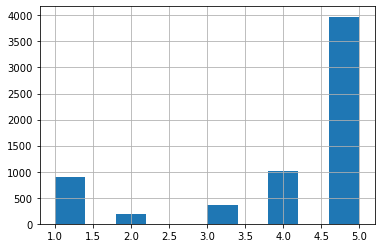

In [828]:
df.ratings.hist()

In [829]:
def rating_to_label(rating) :
  if rating >3:
    return 1
  else:
    return 0
df['y'] = df['ratings'].apply(lambda x : rating_to_label(x))

In [830]:
df

,date,comment,ratings,ko_text,nouns,y
0,2021-04-16,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 5000원만 딱3000원 더 골르면 더...,1,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 원만 딱 원 더 골르면 더있음 쿠폰쓸수...,"[가격, 대별, 기능, 원만, 쿠폰]",0
1,2021-04-16,물품다양 고퀄리티 원료굿 배송굿 서비스굿,5,물품다양 고퀄리티 원료굿 배송굿 서비스굿,"[다양, 퀄리티, 원료]",1
2,2021-04-16,추 .ㅊ. ㅓ.ㅇ .ㅣ : ( 222444 ) 진짜 좋아요.~~^^ 잘 사용.하고 ...,5,추 ㅊ ㅓ ㅇ ㅣ 진짜 좋아요 잘 사용 하고 있습니다 실은 전에 쿠팡 로켓프 레쉬를...,"[진짜, 쿠팡, 레쉬, 배달, 상품, 박스, 어서, 회원, 탈퇴, 상품, 배달, 사...",1
3,2021-04-15,다 좋은데 후기 수정할 수 있으면 좋겠어요,4,다 좋은데 후기 수정할 수 있으면 좋겠어요,"[후기, 수정]",1
4,2021-04-15,가입은 진즉에 했는데 첫주문을 뒤늦게 하면서 왜 이제서야 주문을 했는지 후회막심입니...,5,가입은 진즉에 했는데 첫주문을 뒤늦게 하면서 왜 이제서야 주문을 했는지 후회막심입니...,"[가입, 진즉, 후회, 막심, 실패, 이지, 관심, 상품, 등록]",1
...,...,...,...,...,...,...
6412,2016-03-25,사이트에서 구매하며,5,사이트에서 구매하며,"[사이트, 구매]",1
6413,2016-03-02,매일 출근하면 컬리 사이트 보는게 일과였던 요즘~~ㅎㅎ 앱 출시로 더 가까이 접하게...,5,매일 출근하면 컬리 사이트 보는게 일과였던 요즘 ㅎㅎ 앱 출시로 더 가까이 접하게 ...,"[매일, 출근, 사이트, 일과, 출시, 가까이, 맞벌이, 사이트, 신랑, 널리, 널...",1
6414,2016-03-02,"시행착오가 있을듯은 하나,",1,시행착오가 있을듯은 하나,[시행착오],0
6415,2016-03-02,드뎌 컬리앱이 나왔네요,5,드뎌 컬리앱이 나왔네요,[드뎌],1


In [831]:
df.y.value_counts()

1    4981
0    1436
Name: y, dtype: int64

In [858]:
y= df['y']
X_train,X_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size = 0.3, random_state=32)

In [859]:
print(X_test.shape)

(1926, 3751)


# 로지스틱 회귀

In [860]:
#불용어 배송 아래부터 바꾸면 됨 배송이란 단어를 남기고싶으면
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", max_iter=500)
lr.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(lr.score(X_test, y_test)*100,2)))

Test Accuracy: 84.27%


In [861]:
scores = cross_val_score(lr, tf_idf_vect, y, cv=15) # model, train, target, cross validation

print('cross-val-score \n{}'.format(scores))

print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

cross-val-score 
[0.82242991 0.85514019 0.83411215 0.85280374 0.84813084 0.85514019
 0.86448598 0.87383178 0.81542056 0.83411215 0.81308411 0.85280374
 0.81733021 0.83606557 0.81967213]
cross-val-score.mean 
0.840


In [862]:
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Classifier report: \n\n", classification_report(y_test, y_pred_lr))

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.82      0.42      0.55       448
           1       0.85      0.97      0.90      1478

    accuracy                           0.84      1926
   macro avg       0.83      0.69      0.73      1926
weighted avg       0.84      0.84      0.82      1926



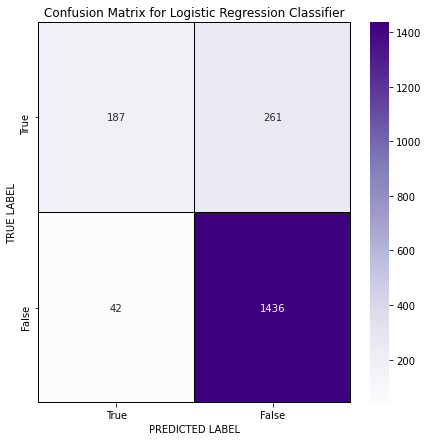

In [863]:
cm = confusion_matrix(y_test, y_pred_lr)
x_axis_labels = ["True", "False"]
y_axis_labels = ["True", "False"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Logistic Regression Classifier')
#plt.savefig("lrcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

In [864]:
# plt.rcParams['figure.figsize'] = [10,8]
# plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [865]:
coef_pos_index = sorted(((value, index ) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value,index) for index, value in enumerate(lr.coef_[0])), reverse= False)

In [869]:
for coef in coef_pos_index[:100]:
  print(invert_index_vectorizer[coef[1]], coef[0])

최악 -3.0231031639252617
가입 -2.933080041675633
문의 -2.7580583794919606
그냥 -2.5453958949547593
블랙리스트 -2.4866810565943225
페이지 -2.4247504070403805
오류 -2.3935892232896534
광고 -2.3053464661689422
다운 -2.238965598217565
삭제 -2.122404916898494
다시 -2.052021781108354
회원 -2.0492210956448935
탈퇴 -2.0427869174065627
실망 -1.939440255261544
제대로 -1.9028518208236898
별로 -1.8684196894518617
연결 -1.8595737091316011
노트 -1.8415353662636447
설치 -1.8377525034190998
엉망 -1.7997688498031428
아예 -1.7756432847734032
로그인 -1.7745248661799065
며칠 -1.7105510399524746
장난 -1.697556399858792
고객 -1.6949322587791364
카톡 -1.6735078118413773
환불 -1.653524717397454
과대 -1.6447827172880196
이유 -1.6413830586891738
인증 -1.6109646010179037
에러 -1.603889535739074
업데이트 -1.6032119164593082
마감 -1.6022716593934274
전혀 -1.5967536190558977
다운로드 -1.5827120309016363
제주도 -1.5810002301930017
결제 -1.5158304900925108
와이파이 -1.5094775558290725
이건 -1.4960704847980313
입력 -1.4766417920290442
장점 -1.4651818975708162
절대 -1.462201370068891
수정 -1.4558547044890304
사라 -1.4